In [2]:
import astropy.units as u
from specutils import Spectrum1D
from astrodb_utils.spectra import check_spectrum_plottable
from specutils import Spectrum, SpectralRegion
from specutils.manipulation import snr_threshold
from astropy.nddata import StdDevUncertainty
from specutils.manipulation import extract_region
from specutils.manipulation import median_smooth
import os
import numpy as np
import csv

INFO     - astrodb_utils.publications - logger.parent.name: astrodb_utils, logger.parent.level: 20


In [3]:
path = "/Users/guanying/SIMPLE_Archive/SIMPLE-db/scripts/spectra_convert/BONES Archive/BONES SPECTRA/"

Reading LRIS spectra LRIS_1333p2735.txt


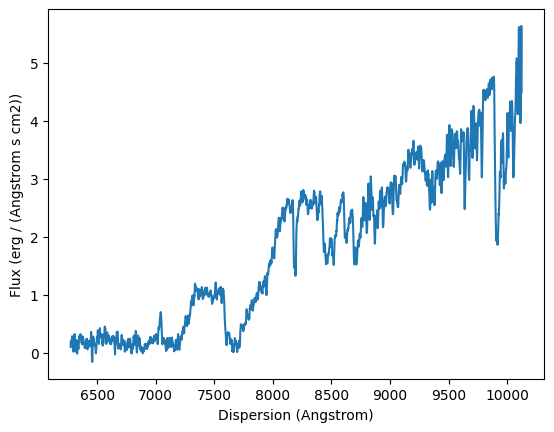

LRIS_1333p2735.txt is plottable
Reading mosfire spectra mosfire_NIR_Wolf1130B.txt


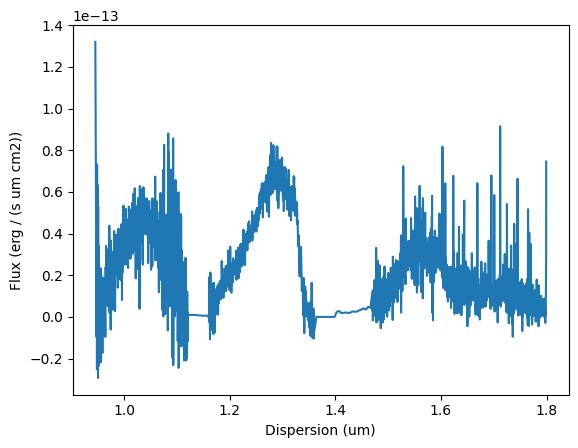

mosfire_NIR_Wolf1130B.txt is plottable


In [4]:
# process mosfire and LRIS with NIR spectra --
for filename in os.listdir(path):
    if filename.startswith("LRIS"):
        print(f"Reading LRIS spectra {filename}")

        data = np.loadtxt(os.path.join(path, filename))
        wavelength = data[:, 0] * u.Angstrom
        flux = data[:, 1] * u.erg/(u.cm**2 * u.s * u.Angstrom)

        # Create Spectrum object with uncertainty
        spectrum = Spectrum(
            flux=flux,
            spectral_axis=wavelength,
        )
        if check_spectrum_plottable(spectrum, show_plot=True):
            print(f"{filename} is plottable")
    
    elif filename.startswith("mosfire"):
        print(f"Reading mosfire spectra {filename}")
        data = np.loadtxt(os.path.join(path, filename))
        wavelength = data[:, 0] * u.um
        flux = data[:, 1] * u.erg/(u.cm**2 * u.s * u.um)
        spectrum = Spectrum(flux=flux, spectral_axis=wavelength)
        if check_spectrum_plottable(spectrum, show_plot=True):
            print(f"{filename} is plottable")

Reading NIRSPEC spectra NIR_J1810-1009.txt


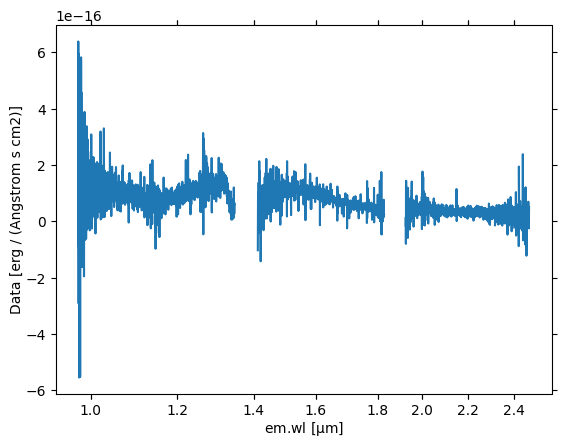

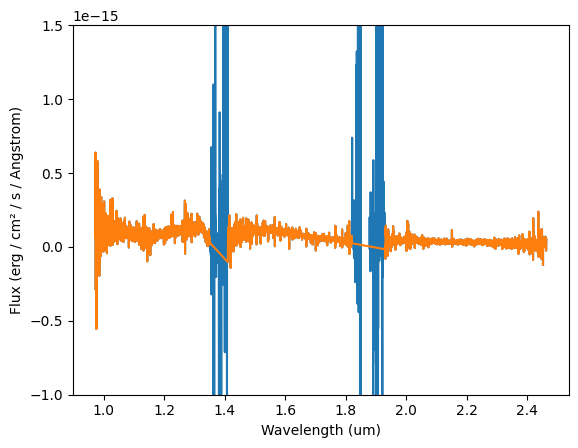

Reading NIRSPEC spectra NIR_J1316+0755_Burn2014.txt


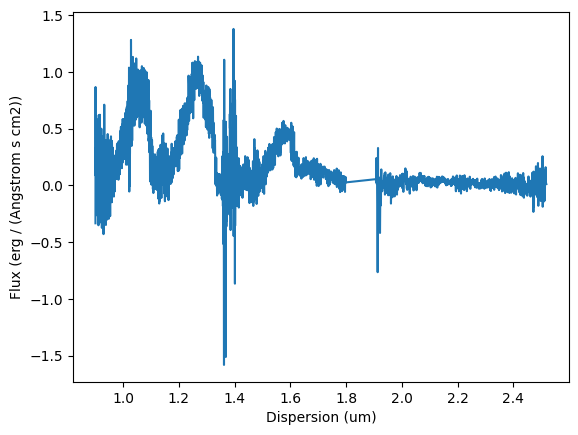

In [16]:
# handle NIR spectra with txt file --
import matplotlib.pyplot as plt
for filename in os.listdir(path):
    if filename.startswith("NIR") and filename.endswith(".txt"):
        print(f"Reading NIRSPEC spectra {filename}")

        data = np.genfromtxt(
            os.path.join(path, filename),
            skip_header=2
        ) 
        wavelength = data[:, 0] * u.um
        flux = data[:, 1] * u.erg/(u.cm**2 * u.s * u.Angstrom)

        # Create Spectrum object

        if "NIR_J1810-1009.txt" in filename:
            mask = (
                ((wavelength.value > 1.35) & (wavelength.value < 1.41)) |
                ((wavelength.value > 1.82) & (wavelength.value < 1.93)) |
                (wavelength.value > 2.5) |
                (wavelength.value < 0.7)
            )
            spectrum = Spectrum(
                flux=flux,
                spectral_axis=wavelength,
                mask=mask
            )
            spectrum.plot()

            fig, ax = plt.subplots()
            ax.plot(spectrum.spectral_axis, spectrum.flux)
            ax.plot(spectrum.spectral_axis[~spectrum.mask], spectrum.flux[~spectrum.mask])
            ax.set_ylim(-1e-15, 1.5e-15)
            ax.set_xlabel("Wavelength (um)")
            ax.set_ylabel("Flux (erg / cm² / s / Angstrom)")
            plt.show()
    
        else:
            spec = Spectrum(
                flux=flux,
                spectral_axis=wavelength,
            )
            check_spectrum_plottable(spec, show_plot=True)

Reading NIRSPEC spectra nirspec_0014m0838.txt
[ 0.800365  0.407071  0.620438 ... -1.06778   0.377945 -0.163505]


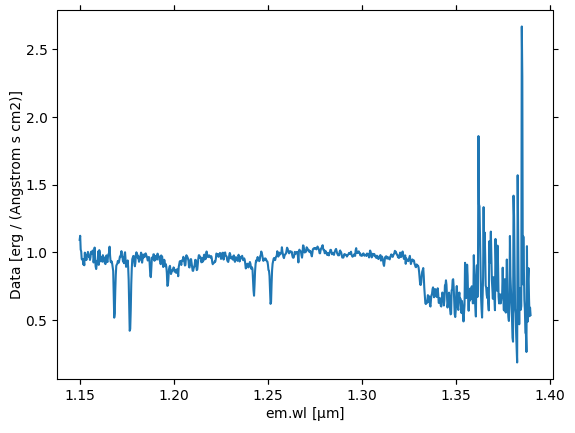

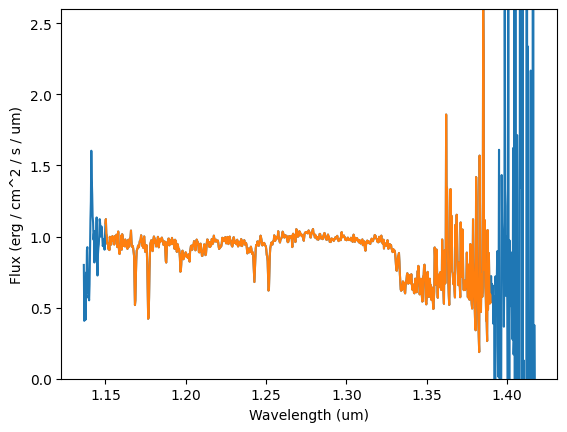

In [46]:
# other case for NIRSPEC txt file
for filename in os.listdir(path):
    if filename.startswith("nirspec") and filename.endswith(".txt"):
        print(f"Reading NIRSPEC spectra {filename}")

        data = np.genfromtxt(os.path.join(path, filename))

        wavelength = data[:, 0] * u.um
        flux = data[:, 1] * u.erg/(u.cm**2 * u.s * u.Angstrom)

        mask = np.logical_or(
            wavelength.value < 1.15, wavelength.value > 1.39
        )
        # Create Spectrum object with mask
        spectrum = Spectrum(
            flux=flux,
            spectral_axis=wavelength,
            mask=mask
        )
        print(flux.value)

        spectrum.plot()
        ax = plt.subplots()[1]
        ax.plot(spectrum.spectral_axis, spectrum.flux)
        ax.plot(spectrum.spectral_axis[~spectrum.mask], spectrum.flux[~spectrum.mask])
        ax.set_ylim(0, 2.6)
        ax.set_xlabel('Wavelength (um)')
        ax.set_ylabel('Flux (erg / cm^2 / s / um)')


Reading NIRSPEC spectra nires_NIR_J1553+6934_20200707.txt


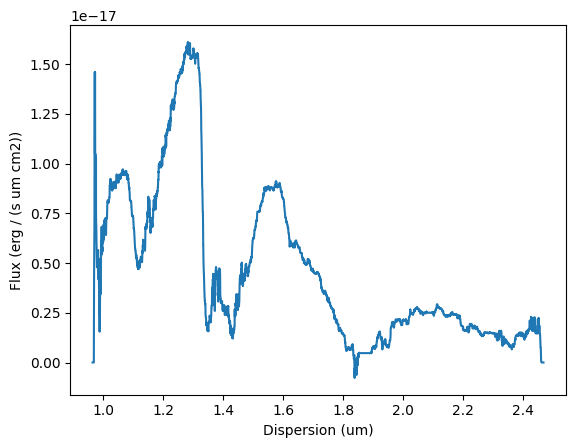

nires_NIR_J1553+6934_20200707.txt is plottable

Reading NIRSPEC spectra nires_NIR_GJ576B_20220611.txt


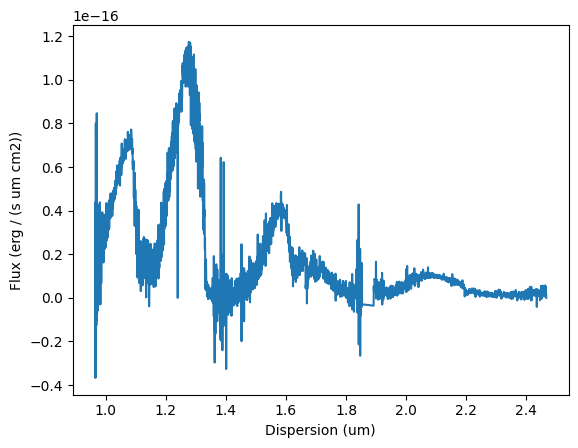

nires_NIR_GJ576B_20220611.txt is plottable



In [10]:
# other case for NIRSPEC txt file, special case for this two plot -- the wavelength is not in order
for filename in os.listdir(path):
    if filename.startswith("nires") and filename.endswith(".txt"):
        print(f"Reading NIRSPEC spectra {filename}")

        data = np.genfromtxt(
            os.path.join(path, filename)
        )

        # sort and remove NULL data value
        data = data[~np.isnan(data).any(axis=1)]
        data = data[np.argsort(data[:, 0])]

        wavelength = data[:, 0] * u.um
        flux = data[:, 1] * (u.erg / u.cm**2 / u.s / u.um)
            
        spectrum = Spectrum(flux=flux, spectral_axis=wavelength)
        
        # the plot in paper is smoothed
        if "nires_NIR_J1553+6934_20200707.txt" in filename:
            smoothed = median_smooth(spectrum, width=101)
            spectrum = Spectrum(flux=smoothed.flux, spectral_axis=wavelength)

        if check_spectrum_plottable(spectrum, show_plot=True):
            print(f"{filename} is plottable\n")

Reading nires_NIR_J0532+8246_20220119.csv
[1.6574937e-16 9.1535750e-17 1.8085605e-16 ... 1.9524366e-17 1.5102998e-17
 1.7093567e-17]


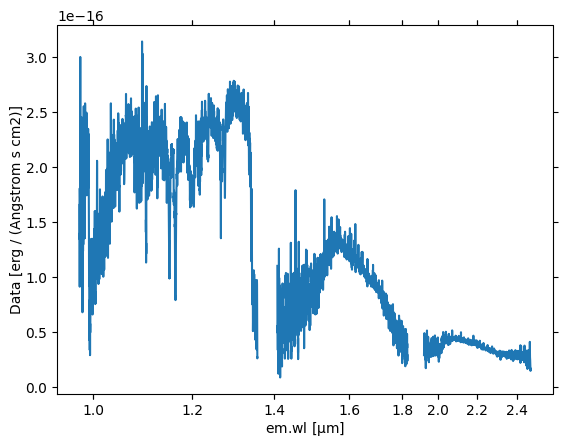

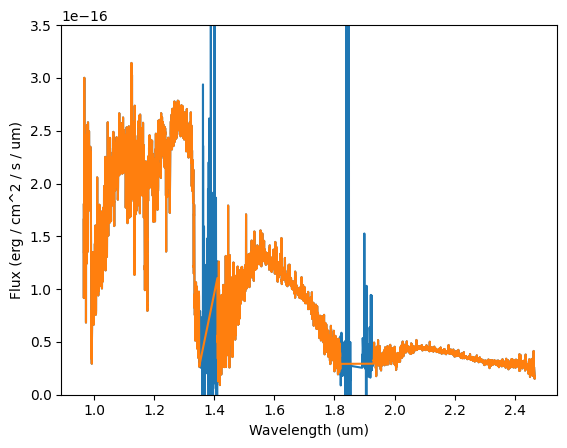

In [48]:
# handle NIRspec with csv file --- cannot compare with research paper as still in preparation
for filename in os.listdir(path):
    if filename.endswith(".csv") and (filename.startswith("nires")):
        file_path = os.path.join(path, filename)
        print(f"Reading {filename}")
        
        data = np.genfromtxt(file_path, delimiter=",", skip_header=1)

        wavelength = data[:, 0] * u.um
        flux = data[:, 1] * (u.erg / u.cm**2 / u.s / u.AA)
        mask = (
            ((wavelength.value > 1.35) & (wavelength.value < 1.41)) |
            ((wavelength.value > 1.82) & (wavelength.value < 1.93)) |
            (wavelength.value > 2.5) |
            (wavelength.value < 0.7)
        )

        # Create Spectrum object with uncertainty
        spectrum = Spectrum(
            flux=flux,
            spectral_axis=wavelength,
            mask=mask
        )
        print(flux.value)

        spectrum.plot()
        ax = plt.subplots()[1]
        ax.plot(spectrum.spectral_axis, spectrum.flux)
        ax.plot(spectrum.spectral_axis[~spectrum.mask], spectrum.flux[~spectrum.mask])
        ax.set_ylim(0, 3.5e-16)
        ax.set_xlabel('Wavelength (um)')
        ax.set_ylabel('Flux (erg / cm^2 / s / um)')



Reading NIR_J0850-0221.csv


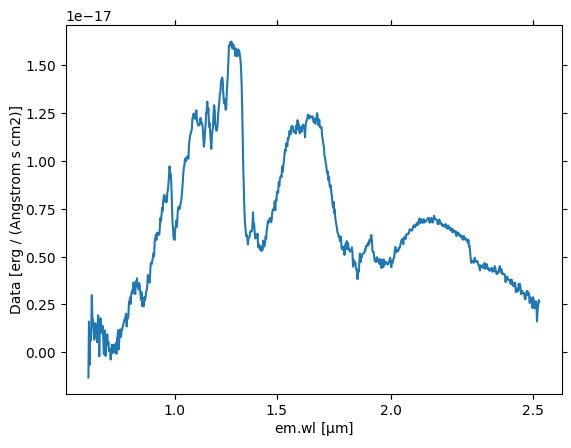

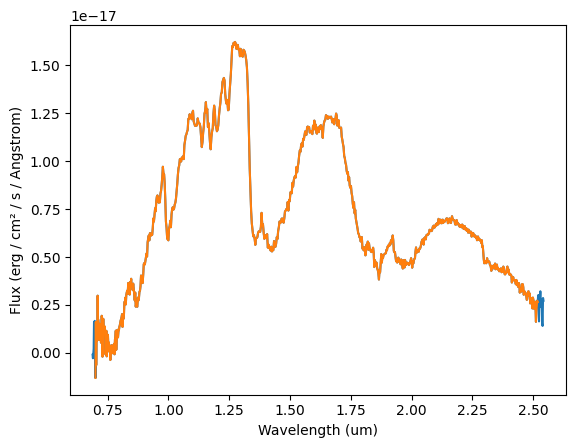

Reading NIR_J0948-2903.csv


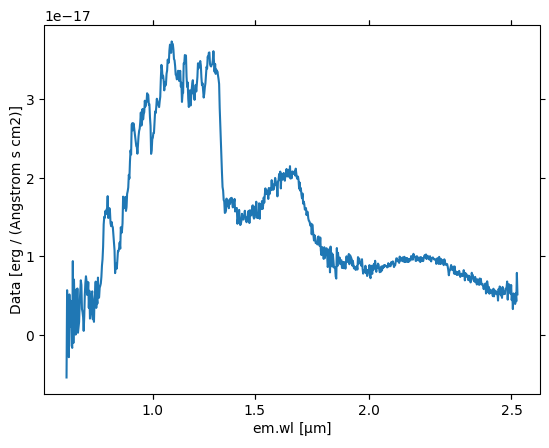

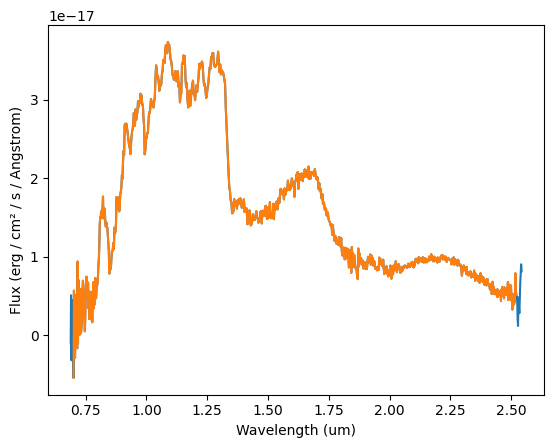

Reading NIR_J1820+2021.csv


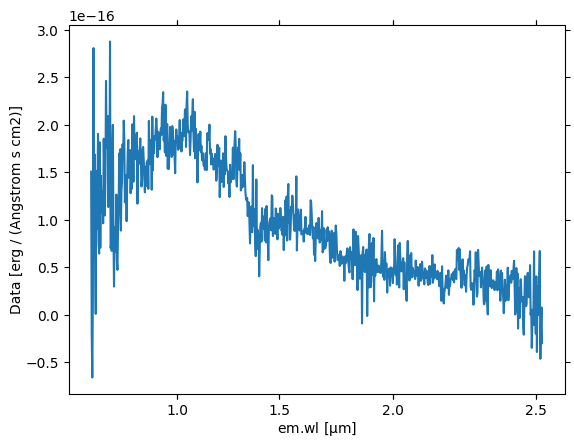

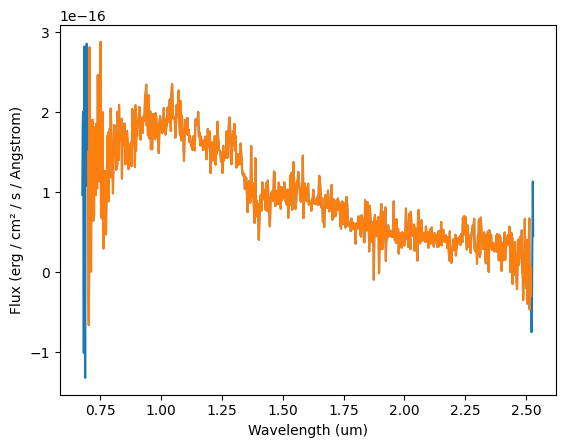

Reading NIR_J1552+0951.csv


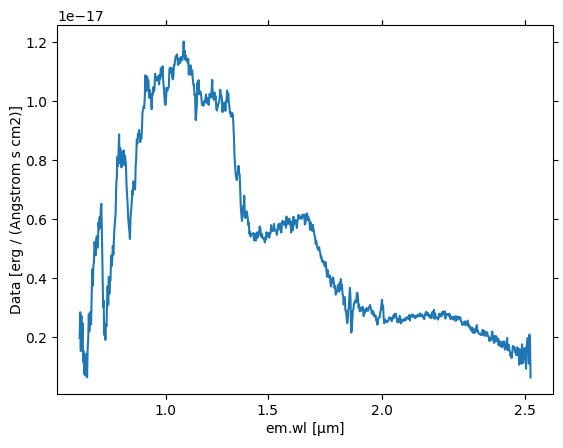

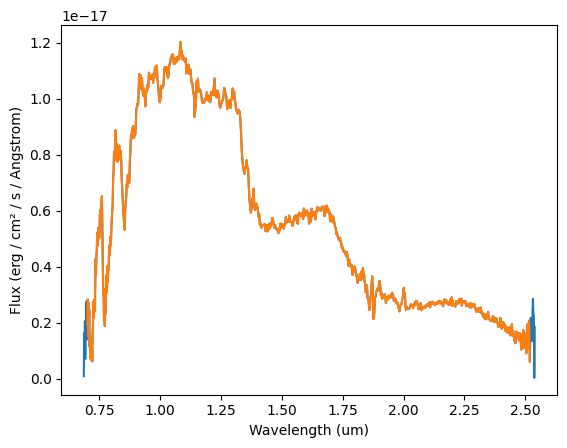

Reading NIR_J1219+0810.csv


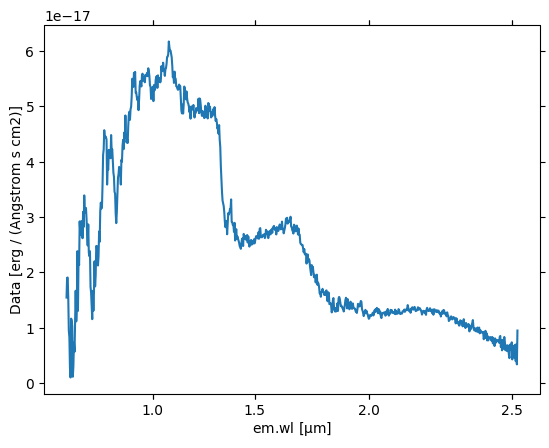

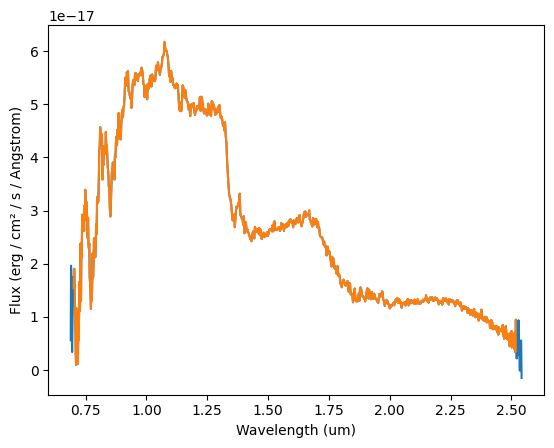

Reading NIR_J1440-2225.csv


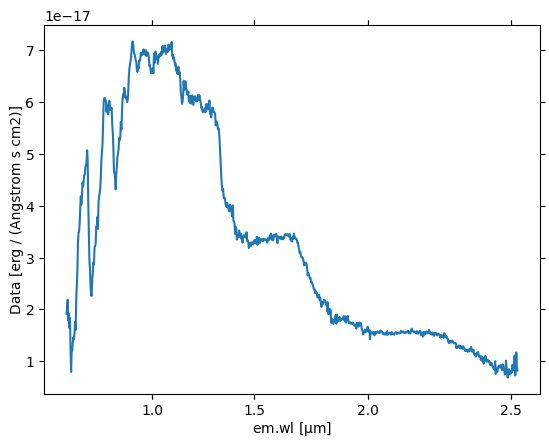

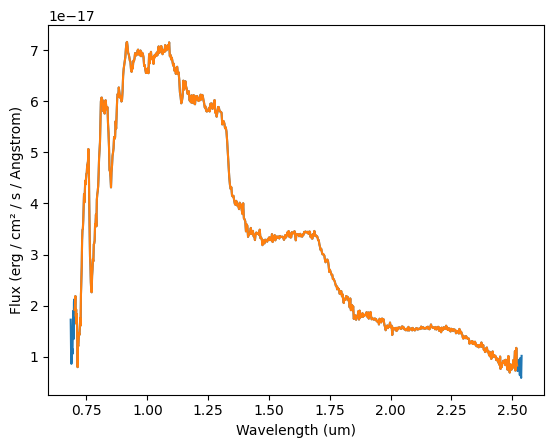

Reading NIR_J1245+6016.csv


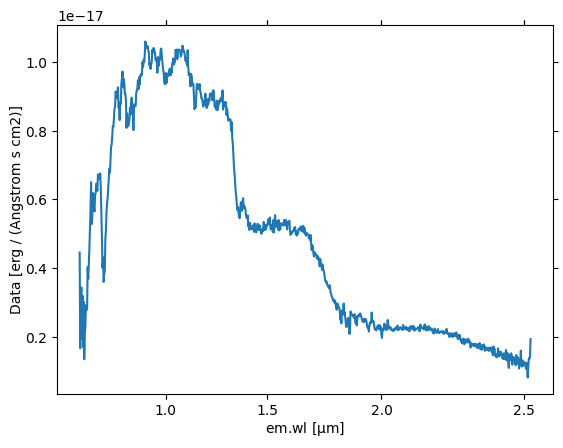

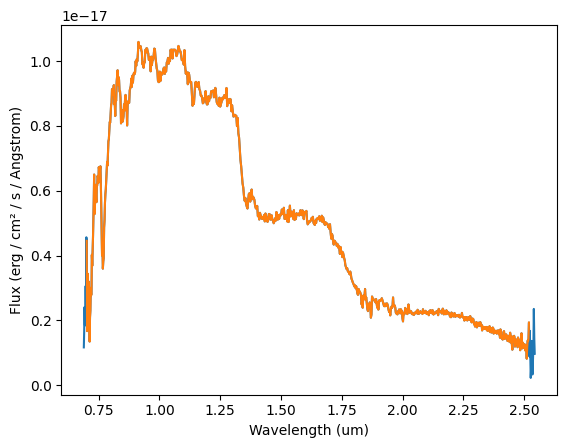

Reading NIR_J0301-2319.csv


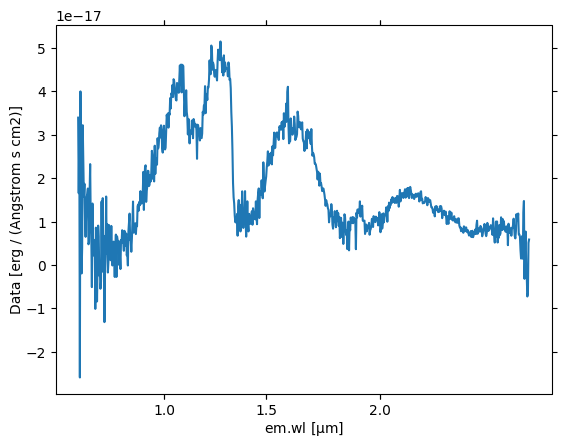

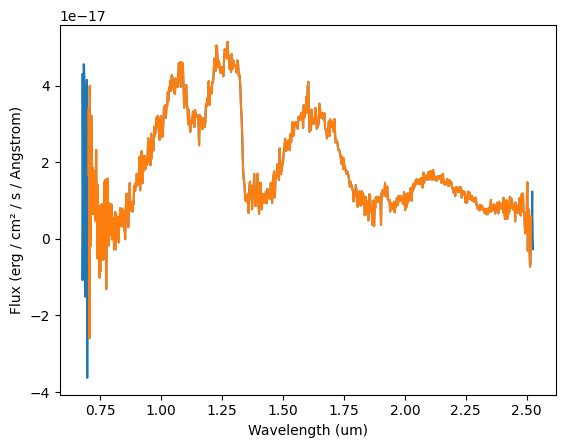

Reading NIR_J1439-1100.csv


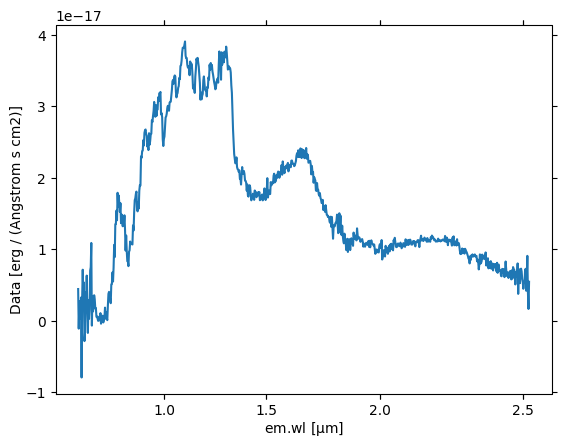

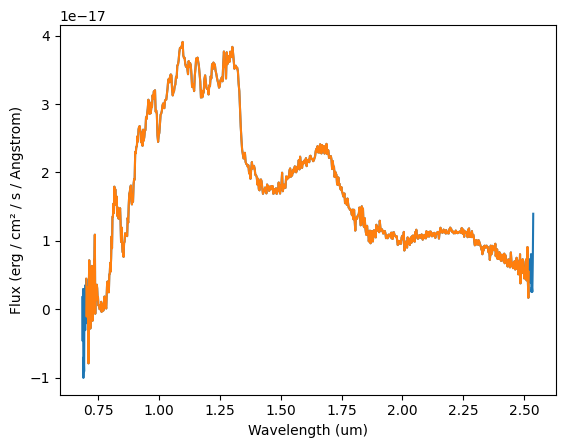

Reading NIR_J1220+6205.csv


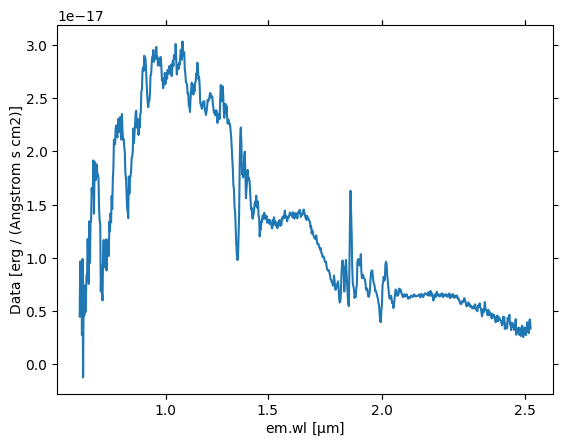

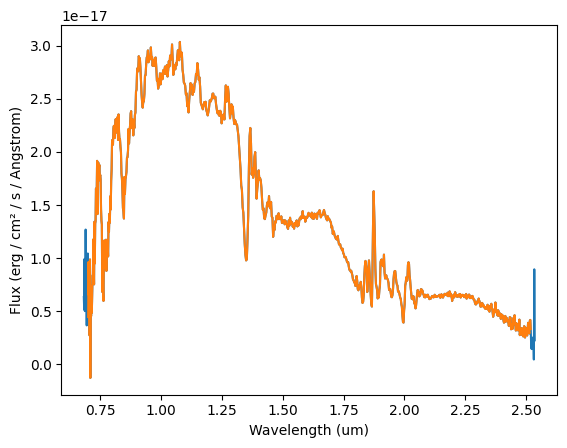

Reading NIR_J1035-0771.csv


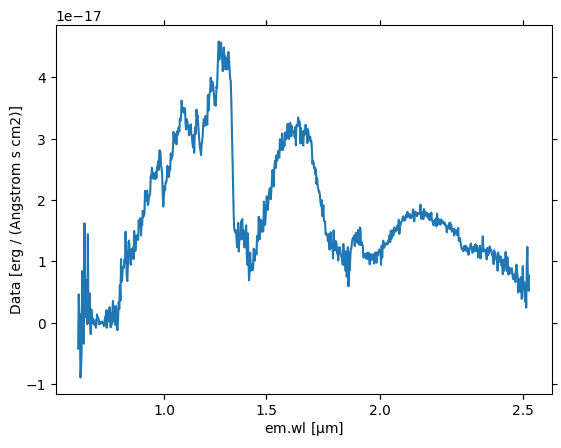

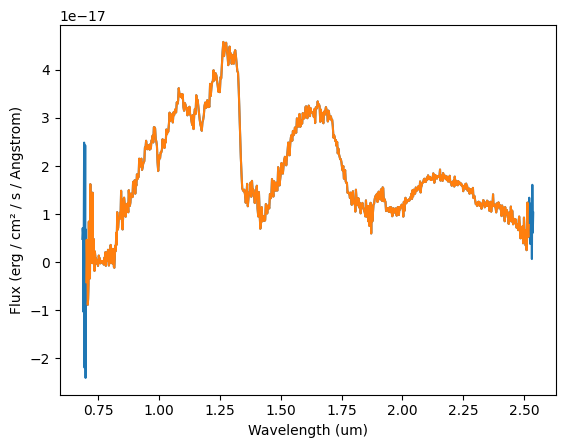

Reading NIR_J0004-2604.csv


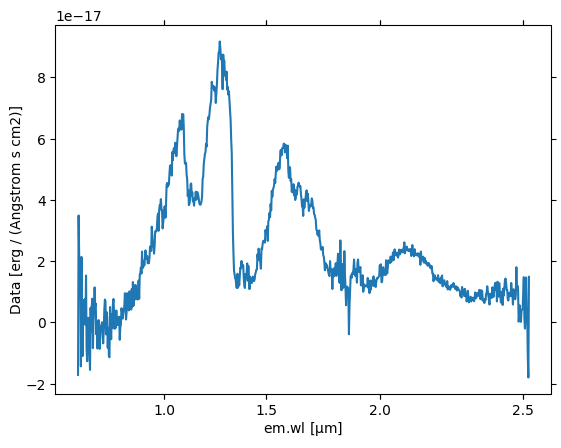

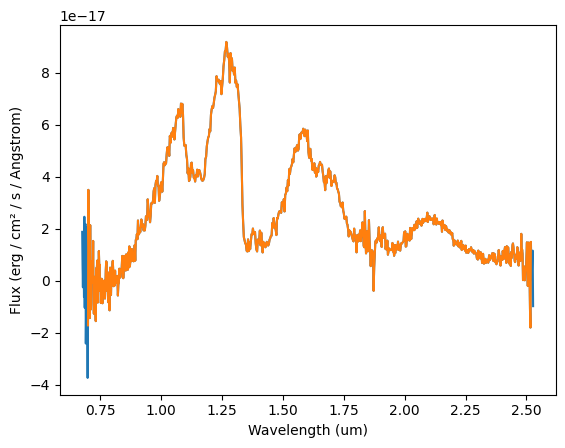

plotted file: 12


In [58]:
# handle NIRspec with csv file ---
file_failed = 0
file_plotted = 0
for filename in os.listdir(path):
    if filename.endswith(".csv") and (filename.startswith("NIR")):
        file_path = os.path.join(path, filename)
        print(f"Reading {filename}")
        
        data = np.genfromtxt(file_path, delimiter=",", skip_header=1)

        wavelength = data[:, 0] * u.um
        flux = data[:, 1] * (u.erg / u.cm**2 / u.s / u.AA)
        mask = np.logical_or(wavelength.value < 0.7, wavelength.value > 2.52)

        spectrum = Spectrum(flux=flux, spectral_axis=wavelength, mask=mask)
        spectrum.plot()

        fig, ax = plt.subplots()
        ax.plot(spectrum.spectral_axis, spectrum.flux)
        ax.plot(spectrum.spectral_axis[~spectrum.mask], spectrum.flux[~spectrum.mask])
        ax.set_xlabel("Wavelength (um)")
        ax.set_ylabel("Flux (erg / cm² / s / Angstrom)")
        plt.show()
        file_plotted += 1

print(f"plotted file: {file_plotted}")
        